✅ Classes found: ['CRACKED', 'UNCRACKED']
🕒 Epoch [1/10] | Train Loss: 0.6904, Train Acc: 59.50% | Val Loss: 0.6761, Val Acc: 80.58%
🕒 Epoch [2/10] | Train Loss: 0.6667, Train Acc: 76.59% | Val Loss: 0.6629, Val Acc: 91.26%
🕒 Epoch [3/10] | Train Loss: 0.6519, Train Acc: 88.37% | Val Loss: 0.6565, Val Acc: 90.29%
🕒 Epoch [4/10] | Train Loss: 0.6438, Train Acc: 92.92% | Val Loss: 0.6514, Val Acc: 89.32%
🕒 Epoch [5/10] | Train Loss: 0.6410, Train Acc: 95.05% | Val Loss: 0.6486, Val Acc: 86.41%
🕒 Epoch [6/10] | Train Loss: 0.6397, Train Acc: 95.09% | Val Loss: 0.6469, Val Acc: 86.41%
🕒 Epoch [7/10] | Train Loss: 0.6375, Train Acc: 95.91% | Val Loss: 0.6447, Val Acc: 87.38%
🕒 Epoch [8/10] | Train Loss: 0.6363, Train Acc: 96.95% | Val Loss: 0.6448, Val Acc: 86.41%
🕒 Epoch [9/10] | Train Loss: 0.6351, Train Acc: 97.16% | Val Loss: 0.6431, Val Acc: 88.35%
🕒 Epoch [10/10] | Train Loss: 0.6341, Train Acc: 97.47% | Val Loss: 0.6411, Val Acc: 89.32%


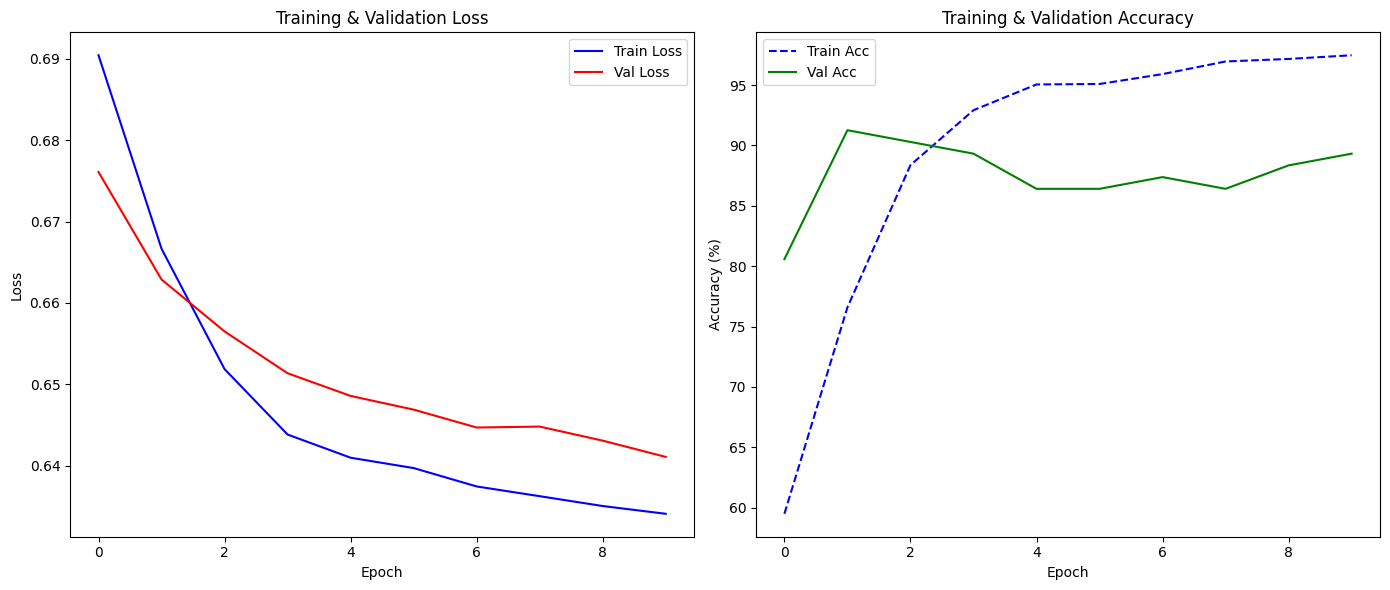


✅ Best Validation Accuracy: 91.26%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ========================
# 📦 Import Libraries
# ========================
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

# ========================
# 🔐 Reproducibility
# ========================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ========================
# 🛠️ User Defined Paths
# ========================
train_dir = '/content/drive/MyDrive/5000 IMAGES'
val_dir = '/content/drive/MyDrive/VALIDATION'

# ========================
# 🔁 Transforms (Stronger Augmentation)
# ========================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ========================
# 🧐 Load Datasets
# ========================
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"✅ Classes found: {class_names}")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ========================
# 🫠 VGG16 Model (with Higher Dropout)
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg16(weights=VGG16_Weights.DEFAULT)
model.classifier = nn.Sequential(
    nn.Linear(25088, 64),
    nn.ReLU(True),
    nn.Dropout(0.9),  # Increased Dropout
    nn.Linear(64, num_classes)
)
model = model.to(device)

# ========================
# 🍣 Label Smoothing Loss
# ========================
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.3):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes

    def forward(self, x, target):
        pred = x.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.3)
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-2)  # Increased weight decay

# ========================
# 🚀 Training Function
# ========================
def train_model(model, train_loader, val_loader, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_running_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"🕒 Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)

    # ========================
    # 📊 Plotting
    # ========================
    plt.figure(figsize=(14, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(val_losses, label="Val Loss", color='red')
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot([x * 100 for x in train_accuracies], label="Train Acc", linestyle='--', color='blue')
    plt.plot([x * 100 for x in val_accuracies], label="Val Acc", color='green')
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\n✅ Best Validation Accuracy: {best_val_acc*100:.2f}%")
    return model

# ========================
# 🚃 Train Model
# ========================
trained_model = train_model(model, train_loader, val_loader, num_epochs=10)

# ========================
# 💾 Save Downloadable Model
# ========================
torch.save(trained_model.state_dict(), "vgg16_final_model.pth")
from google.colab import files
files.download("vgg16_final_model.pth")



📊 Classification Report:
              precision    recall  f1-score   support

     CRACKED       0.93      0.91      0.92        58
   UNCRACKED       0.89      0.91      0.90        45

    accuracy                           0.91       103
   macro avg       0.91      0.91      0.91       103
weighted avg       0.91      0.91      0.91       103



/tmp/ipython-input-5-1010176682.py:34: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


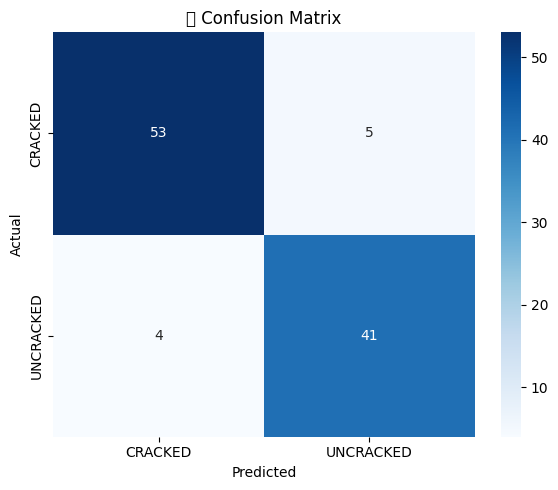

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set model to evaluation mode
trained_model.eval()

# Store true and predicted labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = trained_model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("🔍 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
